<a href="https://colab.research.google.com/github/lclarte/Controle_Quantique/blob/master/Simulation_controle_quantique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from scipy.integrate import complex_ode

Nous commençons par définir la fonction pour calculer l'évolution du vecteur $ \Phi $, en fonction de la matrice H(u, v)

In [0]:
def U_rotation(E, delta_t, t): #Calcule la matrice de rotation Psi -> Phi
  a = 1j * (E*t + delta_t/2)
  return np.array([[np.exp(a), 0.0],
                   [0.0, np.exp(-a)]])

def H_u_v(alpha, E, controle): #matrice d'évolution de l'état Phi
  u,v = controle
  w = v/2 - (alpha - 1.0)*E
  return np.array([[-w, u], 
                   [u, w]])

def derivee_Phi(alpha, E, controle, Phi):
  return -1j * np.dot(H_u_v(alpha, E, controle), Phi)

In [0]:
#On définit l'évolution du controle (u(t), v(t)) sous la forme d'un demi-cercle
#(car on peut calculer analytiquement l'évolution de l'état Phi avec ce contrôle)

def gamma(t): #en t = 0 : (0, -1); en t = 1 : (0, 1)
  return (np.sin(t*np.pi), np.cos(t*np.pi))

def gamma_scale(t, v_i, v_f): #change l'echelle du controle pour s'adapter aux valeurs de alpha
  if v_i > v_f:
    v_f, v_i = v_i, v_f
  milieu = (v_i + v_f)/2
  ecart = (v_f - v_i)/2 #rayon du cercle 
  g = gamma(t)
  return (g[0]*ecart, g[1]*ecart + milieu)

def contraintes_v(E, alpha_min, alpha_max): #retourne les valeurs (v_min,v_max) pour que le controle fonctionne
  assert alpha_min < 1 and alpha_max > 1
  return (2*(alpha_min - 1)*E, 2*(alpha_max- 1)*E) #il faut v_i < v_min, v_f > v_max

In [0]:
Phi_init = np.array([1.0, 0.0])
Phi_cible= np.array([0.0, 1.0])

def evolution_Phi(alpha, E, controle, T, N): 
  "Prend en argument la fonction gamma qui sera l'evolution de notre controle\
  ainsi que l'etat initial, le temps final et le nombre de pas\
  on va faire une homothetie temporelle pour que gamma aille de 0 a T"
  liste_Phis = np.zeros((N, 2), dtype=np.complex_)
  liste_tps = [0.0]*N
  liste_Phis[0] = Phi_init
  T = float(T)
  f = lambda t, y: derivee_Phi(alpha, E, controle(t/T), y)
  r = complex_ode(f)
  r.set_initial_value(liste_Phis[0], liste_tps[0])
  dt = T/(N-1)
  k = 1
  while r.successful() and k < N: #k < N
    liste_tps[k] = r.t+dt
    liste_Phis[k] = r.integrate(r.t + dt)
    k += 1
  return liste_tps, liste_Phis

def vecteur_final(alpha, E, controle, T, N):
  liste_tps, liste_Phis = evolution_Phi(alpha, E, controle, T, N)
  return liste_Phis[N-1]

def distance_finale(alpha, E, controle, T, N): 
  "retourne la distance finale au vecteur (0, 1), A ROTATION PRES"
  vec_final = vecteur_final(alpha, E, controle, T, N)
  a, b = vec_final[0], vec_final[1]
  return np.absolute(a)**2 + (1-np.absolute(b))**2


In [0]:
import matplotlib.pyplot as plt

"""
Fonctions d'affichage des resultats
"""

def afficher_evolution_Phi(liste_tps, liste_Phis):
  plt.plot(liste_tps, np.absolute(liste_Phis[:, 0]))
  plt.plot(liste_tps, np.absolute(liste_Phis[:, 1]))
  plt.show()
  
def distances_finales_alpha(controle):
  "Calcule la distance de l'etat final au vecteur (0, 1) (a rotation pres) en fonction de alpha"
  alphas, distances = [], []
  alpha = alpha_min
  while alpha < alpha_max:
    distance = distance_finale(alpha, E, controle, T, N)
    alphas.append(alpha)
    distances.append(distance)
    alpha += alpha_step
  return alphas, distances
    
    
  

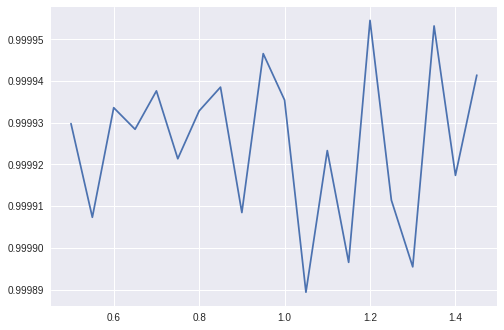

In [0]:
"""
On va fixer E = 1 arbitrairement, et faire varier alpha de alpha_min = 0.5 a 
alpha_max = 1.5, et voir comment l'état final 
"""

alpha_min = 0.5
alpha_max = 1.5
alpha_step = 0.05

E = 1

T = 100.0
N = 1000

def main():
  v_i, v_f = contraintes_v(E, alpha_min, alpha_max)
  controle = lambda t: gamma_scale(t, v_i, v_f) 
  return distances_finales_alpha(controle)
  
  
alphas, distances = main()
plt.plot(alphas, distances)
plt.show()